## Demo of ConfSeq

This is a notebook on how to use convert a 3D molecule into a ConfSeq sequence and vise versa.

### Import nessessary libraries

In [1]:
from rdkit import Chem
from rdkit.Chem.rdDistGeom import EmbedMolecule
from rdkit.Chem.rdForceFieldHelpers import MMFFOptimizeMolecule
from rdkit.Chem.rdMolAlign import GetBestRMS
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True

import py3Dmol
import random
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from ConfSeq import (run_aug_mol_get_ConfSeq_pair_0, 
                     run_aug_mol_get_ConfSeq_pair_1, 
                     run_aug_mol_get_ConfSeq_pair_2, 
                     random_adjust_numbers,
                     replace_angle_brackets_with_line,
                     get_mol_from_ConfSeq_pair,
                     remove_degree_in_molblock)

visualize function

In [2]:
def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D

    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')

    viewer = py3Dmol.view(width=size[0], height=size[1])
    if isinstance(mol, list):
        for i, m in enumerate(mol):
            mblock = Chem.MolToMolBlock(m)
            viewer.addModel(mblock, 'mol' + str(i))
    elif len(mol.GetConformers()) > 1:
        for i in range(len(mol.GetConformers())):
            mblock = Chem.MolToMolBlock(mol, confId=i)
            viewer.addModel(mblock, 'mol' + str(i))
    else:
        mblock = Chem.MolToMolBlock(mol)
        viewer.addModel(mblock, 'mol')
    viewer.setStyle({style: {}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

### Embed a molecule for demostration

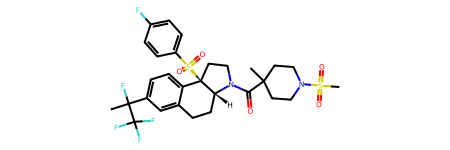

In [3]:
smiles = 'CC(F)(C(F)(F)F)C1=CC=C2C(CC[C@]3([H])[C@@]2(S(C4=CC=C(C=C4)F)(=O)=O)CCN3C(C5(C)CCN(S(C)(=O)=O)CC5)=O)=C1'
mol = Chem.MolFromSmiles(smiles)
mol

In [4]:
mol_with_h = Chem.AddHs(mol)
EmbedMolecule(mol_with_h, randomSeed=42)
MMFFOptimizeMolecule(mol_with_h, maxIters=500)
mol = Chem.RemoveHs(mol_with_h)
MolTo3DView(mol)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Convert the molecule to ConfSeq sequences

In [5]:
def mol2confseq(mols_list, num_workers=10, aug_mode=0, aug_times=1, do_random=False, disable_tqdm=False):
    """
    Convert a list of RDKit molecule objects into their corresponding Conformation Sequence (ConfSeq) strings.

    Parameters:
        mols_list (list): A list of RDKit Mol objects to be processed.
        num_workers (int, optional): Number of parallel workers for processing. Default is 10.
        aug_mode (int, optional): Conformation augmentation mode that determines how the molecule is randomized:
            - 0: Rooted SMILES augmentation at atom index 0 (canonicalized rooted SMILES).
            - 1: Rooted SMILES augmentation at a random atom index (randomized rooted SMILES).
            - 2: Fully randomized atom ordering using random SMILES generation.
        aug_times (int, optional): Number of times to augment each molecule. Default is 1.
        do_random (bool, optional): If True, applies additional random adjustments to the resulting ConfSeq strings. 
                                    Default is False.
        disable_tqdm (bool, optional): If True, disables the progress bar output from tqdm. Default is False.

    Returns:
        confseq_list (list): A list of ConfSeq strings corresponding to each input molecule. 
                            If processing fails, the result for that molecule is 'error'.
    """

    datas = []
    for mol in mols_list:
        if mol is not None:
            datas.append((mol, Chem.MolToSmiles(mol)))

    if aug_mode == 0:
        results_t0 = process_map(
            run_aug_mol_get_ConfSeq_pair_0,
            tqdm(datas * aug_times, disable=disable_tqdm),
            max_workers=num_workers,
            chunksize=1000,
            disable=disable_tqdm
        )
    elif aug_mode == 1:
        results_t0 = process_map(
            run_aug_mol_get_ConfSeq_pair_1,
            tqdm(datas * aug_times, disable=disable_tqdm),
            max_workers=num_workers,
            chunksize=1000,
            disable=disable_tqdm
        )
    elif aug_mode == 2:
        results_t0 = process_map(
            run_aug_mol_get_ConfSeq_pair_2,
            tqdm(datas * aug_times, disable=disable_tqdm),
            max_workers=num_workers,
            chunksize=1000,
            disable=disable_tqdm
        )
    else:
        raise ValueError(f'Invalid aug_mode: {aug_mode}')

    random.seed(42)  
    if do_random:
        for i in range(len(results_t0)):
            if random.random() >= 0.5:
                results_t0[i] = random_adjust_numbers(results_t0[i])
            results_t0[i] = results_t0[i].replace('<180>', '<-180>')

    confseq_list = []
    for i in range(len(results_t0)):
        parts = results_t0[i].split('\t')
        if len(parts) == 3:
            confseq_list.append(parts[2])
        else:
            confseq_list.append('error')

    return confseq_list


#### canonicalized ConfSeq sequence

In [6]:
mol2confseq([mol])

100%|██████████| 1/1 [00:00<00:00, 214.25it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

['C C 1 ( } <57> C <121> | ( = O ) <-16> N 2 <-178> C <21> C <90> [ C @ @ ] 3 ( <-62> S <108> | ( = O ) ( = O ) <-88> c 4 c c c ( F ) c c 4 ) <-56> c 4 c c c ( <-64> [ C @ @ ] ( C ) ( F ) <-58> C ( F ) ( F ) F ) c c 4 <-32> C <60> C <-174> [ C @ @ H ] <161> 2 <23> 3 ) <135> C <41> C <158> { N ( <-165> S <102> | ( C ) ( = O ) = O ) <28> C <33> C <-178> 1']

#### augmented ConfSeq sequences

In [7]:
mol2confseq([mol], aug_mode=1, aug_times=10, do_random=True)

100%|██████████| 10/10 [00:00<00:00, 4883.91it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

['O = C <118> | ( <-16> N 1 <-178> C <21> C <89> [ C @ @ ] 2 ( <-63> S <111> | ( = O ) ( = O ) <-87> c 3 c c c ( F ) c c 3 ) <-58> c 3 c c c ( <-63> [ C @ @ ] ( C ) ( F ) <-58> C ( F ) ( F ) F ) c c 3 <-34> C <57> C <-176> [ C @ @ H ] <160> 1 <23> 2 ) <58> { C 1 ( C ) <137> C <38> C <159> { N ( <-166> S <104> | ( C ) ( = O ) = O ) <29> C <33> C <-178> 1',
 'C 1 <60> C <-174> [ C @ H ] 2 <-76> N ( <172> C <121> | ( = O ) <176> } C 3 ( C ) <-178> C <33> C <161> } N ( <62> S <102> | ( C ) ( = O ) = O ) <-67> C <41> C <135> 3 ) <-6> C <21> C <-27> [ C @ @ ] <-96> 2 ( <52> S <108> | ( = O ) ( = O ) <97> c 2 c c c ( F ) c c 2 ) <-172> c 2 c c c ( <-64> [ C @ @ ] ( C ) ( F ) <-178> C ( F ) ( F ) F ) c c 2 <-32> 1',
 'c 1 c c ( F ) c c c 1 <-88> S <108> | ( = O ) ( = O ) <-62> [ C @ @ ] 1 2 <90> C <21> C <-178> N ( <-16> C <121> | ( = O ) <57> { C 3 ( C ) <135> C <41> C <158> { N ( <-165> S <102> | ( C ) ( = O ) = O ) <28> C <33> C <-178> 3 ) <-11> [ C @ @ H ] <-97> 1 <-56> C <60> C <148> c 1 

### Convert the ConfSeq sequence back to a 3D molecule

In [8]:
def convert_confseq_to_mol(confseq):
    try:
        in_smiles = replace_angle_brackets_with_line(confseq)
        generated_mol = get_mol_from_ConfSeq_pair(in_smiles, confseq)
        generated_mol = Chem.MolFromMolBlock(remove_degree_in_molblock(Chem.MolToMolBlock(generated_mol)))
        if generated_mol is not None:
            return generated_mol
    except Exception as e:
        return f'Error: {e}'
    return None

In [9]:
confseq = mol2confseq([mol], disable_tqdm=True)[0]
confseq

'C C 1 ( { <176> C <121> | ( = O ) <-16> N 2 <-178> C <21> C <90> [ C @ @ ] 3 ( <-62> S <108> | ( = O ) ( = O ) <-88> c 4 c c c ( F ) c c 4 ) <-56> c 4 c c c ( <-64> [ C @ @ ] ( C ) ( F ) <62> C ( F ) ( F ) F ) c c 4 <-32> C <60> C <-174> [ C @ @ H ] <161> 2 <23> 3 ) <-178> C <33> C <161> } N ( <62> S <102> | ( C ) ( = O ) = O ) <-67> C <41> C <135> 1'

In [10]:
mol_recon = convert_confseq_to_mol(confseq)
MolTo3DView(mol_recon)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [11]:
GetBestRMS(mol, mol_recon)

0.22552322787294388

In [12]:
MolTo3DView([mol, mol_recon])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.